In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import json

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
train = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/modeling/mind_19.xlsx', engine='openpyxl')
val = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/modeling/mind_20.xlsx', engine='openpyxl')
inf = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/NH_1118/mind_21.xlsx', engine='openpyxl')

In [ ]:
print(len(train))
print(len(val))
print(len(inf))

252
251
246


In [ ]:
len(train.loc[train['역량평가등급']!='미입사'].loc[train.loc[train['역량평가등급']!='미입사']['역량평가등급']!='미평가'])

152

In [ ]:
train_data = train.copy()
val_data = val.copy()
inf_data = inf.copy()

In [ ]:
# 추가
inf_data = inf_data.drop(['2019_역량평가등급', '2019_업적평가등급', '2020_역량평가등급', '2020_업적평가등급'], axis=1)

In [ ]:
train_data = pd.concat([train_data, val_data, inf_data], axis = 0)
train_data.reset_index(drop=True, inplace = True)
train_data_count = train_data.copy()

In [ ]:
train_data = train_data.loc[train_data['역량평가등급']!='미입사']
train_data = train_data.loc[train_data['역량평가등급']!='미평가']

In [ ]:
train_data['역량평가등급'].value_counts(normalize=True)

B    0.500998
A    0.277445
C    0.217565
S    0.003992
Name: 역량평가등급, dtype: float64

In [ ]:
# 수정 1117
mind_feature = ['긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성',
       '자기긍정', '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동',
       '감정인식', '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성',
       '정직성', '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']

for name in mind_feature :
  train_data[name] = train_data[name].fillna(train_data[name].mean())

In [ ]:
random_seed = 1

In [ ]:
train_data['셀 참여횟수'] = train_data['셀 참여횟수'].fillna(0)
train_data['봉사활동 참여횟수'] = train_data['봉사활동 참여횟수'].fillna(0)
train_data['금년 평균 교육점수'] = train_data['금년 평균 교육점수'].replace('미신청', 0)
train_data = train_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책'], axis=1)

train_data['역량평가등급'].replace('S', 5, inplace=True)
train_data['역량평가등급'].replace('A', 4, inplace=True)
train_data['역량평가등급'].replace('B', 3, inplace=True)
train_data['역량평가등급'].replace('C', 2, inplace=True)
train_data['역량평가등급'].replace('D', 1, inplace=True)

train_data['업적평가등급'].replace('S', 5, inplace=True)
train_data['업적평가등급'].replace('A', 4, inplace=True)
train_data['업적평가등급'].replace('B', 3, inplace=True)
train_data['업적평가등급'].replace('C', 2, inplace=True)
train_data['업적평가등급'].replace('D', 1, inplace=True)

In [ ]:
X = pd.get_dummies(train_data.drop(['사번', '역량평가등급', '업적평가등급'], axis=1), columns = ['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부'], drop_first = True)
X_temp = pd.get_dummies(train_data.drop(['역량평가등급', '업적평가등급'], axis=1), columns = ['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부'], drop_first = True)
y_f = train_data['역량평가등급']
y_s = train_data['업적평가등급']

X_train, X_test, y_train_f, y_test_f = train_test_split(X, y_f, test_size=0.3, random_state=random_seed)
X_train, X_test, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.3, random_state=random_seed)


In [ ]:
if ((set(X_train.columns)-set(X_test.columns)) != set()) :
  feature = list(set(X_train.columns)-set(X_test.columns))
  for i in range(len(feature)) : 
    X_test[feature[i]] = 0
if ((set(X_test.columns)-set(X_train.columns)) != set()) :
  feature = list(set(X_test.columns)-set(X_train.columns))
  for i in range(len(feature)) : 
    X_train[feature[i]] = 0 

X_test = X_test[X_train.columns]

X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [ ]:
benchmark = pd.DataFrame(columns=['Algorithm', 'MAE', 'RMSE', 'MAPE', 'r2'])

for algorithm in [LinearRegression(), RandomForestRegressor(random_state=random_seed), XGBRegressor(random_state=random_seed),MLPRegressor(random_state=random_seed), Lasso(), Ridge(), GradientBoostingRegressor(random_state=random_seed), 
                  AdaBoostRegressor(random_state=random_seed), ElasticNet(random_state=random_seed), DecisionTreeRegressor(random_state=random_seed), KNeighborsRegressor(), ExtraTreesRegressor(random_state=random_seed)]:
    pipeline = Pipeline(steps = [['regressor', algorithm]])
    
    results = GridSearchCV(estimator=pipeline,
                           scoring= 'neg_mean_absolute_error',
                           param_grid ={},
                           cv = None,
                           n_jobs=-1)
    results.fit(X_train, y_train_f)
    results_pred = results.predict(X_test)
    mae = mean_absolute_error(y_test_f, results_pred)
    rmse = mean_squared_error(y_test_f, results_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test_f, results_pred)
    r2_cof = r2_score(y_test_f, results_pred)
    benchmark = benchmark.append({'Algorithm' : algorithm, 'MAE' : mae,'RMSE' : rmse, 'MAPE' : mape, 'r2' : r2_cof}, ignore_index=True)

[02:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [ ]:
benchmark.sort_values(by='r2', ascending=False)

,Algorithm,MAE,RMSE,MAPE,r2
1,RandomForestRegressor(random_state=1),0.529470,0.668253,0.201120,0.075534
2,XGBRegressor(random_state=1),0.537479,0.682442,0.202688,0.035860
7,AdaBoostRegressor(random_state=1),0.547007,0.695885,0.209083,-0.002499
6,GradientBoostingRegressor(random_state=1),0.552988,0.698191,0.208981,-0.009155
5,Ridge(),0.562572,0.704516,0.210039,-0.027522
8,ElasticNet(random_state=1),0.531154,0.706291,0.203919,-0.032704
4,Lasso(),0.531066,0.708650,0.204617,-0.039614
0,LinearRegression(),0.583980,0.728299,0.219627,-0.098066
11,ExtraTreesRegressor(random_state=1),0.544967,0.729013,0.205909,-0.100220
10,KNeighborsRegressor(),0.580132,0.735477,0.219426,-0.119818


In [ ]:
opt_dict_1 = {}
idx = benchmark['MAPE'].idxmin()
column_list = ['MAE', 'RMSE', 'MAPE', 'r2']
benchmark = benchmark.drop([idx], axis=0).reset_index(drop=True)

for columns in list(column_list) : 
  opt_dict_1['Average '+columns] = benchmark[columns].mean()

opt_dict_1  

{'Average MAE': 0.6491720049840406,
 'Average RMSE': 0.8280027225165721,
 'Average MAPE': 0.2429259772144596,
 'Average r2': -0.6100644185207631}

In [ ]:
benchmark_2 = pd.DataFrame(columns=['Algorithm', 'MAE', 'RMSE', 'MAPE', 'r2'])

for algorithm in [LinearRegression(), RandomForestRegressor(random_state=random_seed), XGBRegressor(random_state=random_seed),MLPRegressor(random_state=random_seed), Lasso(), Ridge(), GradientBoostingRegressor(random_state=random_seed), 
                  AdaBoostRegressor(random_state=random_seed), ElasticNet(random_state=random_seed), DecisionTreeRegressor(random_state=random_seed), KNeighborsRegressor(), ExtraTreesRegressor(random_state=random_seed)]:
    pipeline = Pipeline(steps = [['regressor', algorithm]])
    
    results = GridSearchCV(estimator=pipeline,
                           scoring= 'neg_mean_absolute_error',
                           param_grid ={},
                           cv = None,
                           n_jobs=-1)
    results.fit(X_train, y_train_s)
    results_pred = results.predict(X_test)
    mae = mean_absolute_error(y_test_s, results_pred)
    rmse = mean_squared_error(y_test_s, results_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test_s, results_pred)
    r2_cof = r2_score(y_test_s, results_pred)
    benchmark_2 = benchmark_2.append({'Algorithm' : algorithm, 'MAE' : mae,'RMSE' : rmse, 'MAPE' : mape, 'r2' : r2_cof}, ignore_index=True)

[02:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [ ]:
benchmark_2.sort_values(by='r2', ascending=False)

,Algorithm,MAE,RMSE,MAPE,r2
7,AdaBoostRegressor(random_state=1),0.439161,0.589277,0.145746,0.112578
1,RandomForestRegressor(random_state=1),0.474238,0.597278,0.157833,0.088315
2,XGBRegressor(random_state=1),0.487476,0.618763,0.160550,0.021548
8,ElasticNet(random_state=1),0.431795,0.621807,0.143554,0.011896
4,Lasso(),0.411819,0.626978,0.137555,-0.004609
6,GradientBoostingRegressor(random_state=1),0.506687,0.639232,0.166451,-0.044261
5,Ridge(),0.515756,0.646396,0.167590,-0.067797
0,LinearRegression(),0.519288,0.651493,0.169504,-0.084704
11,ExtraTreesRegressor(random_state=1),0.503775,0.652678,0.166858,-0.088654
10,KNeighborsRegressor(),0.509934,0.672841,0.165497,-0.156956


In [ ]:
opt_dict_2 = {}
idx = benchmark_2['MAPE'].idxmin()
column_list = ['MAE', 'RMSE', 'MAPE', 'r2']
benchmark_2 = benchmark_2.drop([idx], axis=0).reset_index(drop=True)

for columns in list(column_list) : 
  opt_dict_2['Average '+columns] = benchmark_2[columns].mean()

opt_dict_2  

{'Average MAE': 0.5804299862771548,
 'Average RMSE': 0.7549950895638617,
 'Average MAPE': 0.1916658216844054,
 'Average r2': -0.7225462668882646}

In [ ]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_temp, y_f, test_size=0.3, random_state=2) 

train_name_f = X_train_f['사번']
X_train_f.drop(['사번'], axis=1, inplace=True)
X_test_f.drop(['사번'], axis=1, inplace=True)

X_train_f = X_train_f.astype('float')
X_test_f = X_test_f.astype('float')

model_rf = RandomForestRegressor(n_estimators = 100, max_depth=5, min_samples_split=5, random_state=6)
# model_rf = AdaBoostRegressor(n_estimators=100, learning_rate=0.001, random_state=1)

model_rf.fit(X_train_f, y_train_f)
pred_rf = model_rf.predict(X_test_f)

now = datetime.now()

s_mae = mean_absolute_error(y_test_f, pred_rf)
s_rmse = mean_squared_error(y_test_f, pred_rf, squared=False)
s_mape = mean_absolute_percentage_error(y_test_f, pred_rf)
s_r2_cof = r2_score(y_test_f, pred_rf)

metrics_dict_1 = {}
metrics_dict_1['MAE'] = s_mae
metrics_dict_1['RMSE'] = s_rmse
metrics_dict_1['MAPE'] = s_mape
metrics_dict_1['r2_score'] = s_r2_cof

metrics_dict_1

{'MAE': 0.5191918000254843,
 'RMSE': 0.6513015797304907,
 'MAPE': 0.17667437213351433,
 'r2_score': 0.14993481783592677}

In [ ]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_temp, y_s, test_size=0.3, random_state=1) 

train_name_s = X_train_s['사번']
X_train_s.drop(['사번'], axis=1, inplace=True)
X_test_s.drop(['사번'], axis=1, inplace=True)

X_train_s = X_train_s.astype('float')
X_test_s = X_test_s.astype('float')

model_xgb = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)

model_xgb.fit(X_train_s, y_train_s)
pred_xgb = model_xgb.predict(X_test_s)

s_mae = mean_absolute_error(y_test_s, pred_xgb)
s_rmse = mean_squared_error(y_test_s, pred_xgb, squared=False)
s_mape = mean_absolute_percentage_error(y_test_s, pred_xgb)
s_r2_cof = r2_score(y_test_s, pred_xgb)

metrics_dict_2 = {}
metrics_dict_2['MAE'] = s_mae
metrics_dict_2['RMSE'] = s_rmse
metrics_dict_2['MAPE'] = s_mape
metrics_dict_2['r2_score'] = s_r2_cof

metrics_dict_2

{'MAE': 0.4562725935799541,
 'RMSE': 0.5809245935473842,
 'MAPE': 0.15044395937173838,
 'r2_score': 0.13755541194416032}

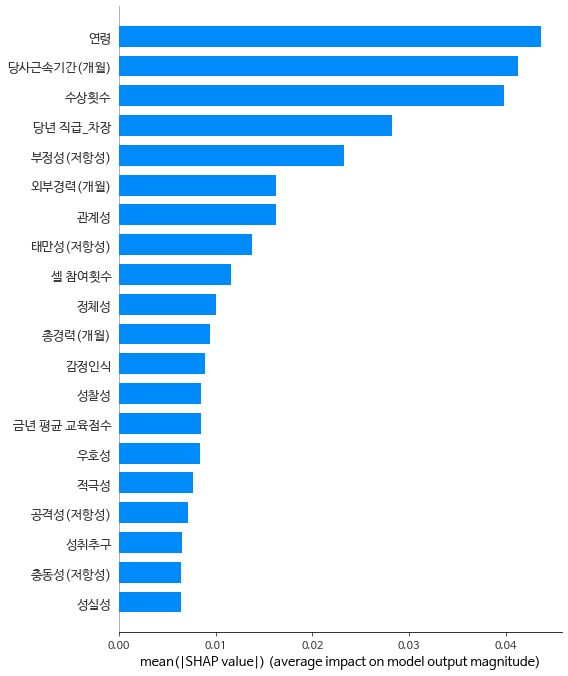

In [ ]:
explainer_1 = shap.TreeExplainer(model_rf, X_train_f) 
shap_values_1 = explainer_1.shap_values(X_test_f) 
shap.initjs()
shap.summary_plot(shap_values_1, X_test_f, plot_type = "bar")

In [ ]:
importances_1 = np.absolute(shap_values_1).sum(axis=0) / shap_values_1.shape[0]
feature_importance_1 = pd.Series(importances_1 / np.sum(importances_1))
feature_importance_1.index = X_train_f.columns

In [ ]:
# 수정 1117
numerical = ['연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수',
       '금년 평균 교육점수', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성',
       '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동',
       '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성',
       '우호성', '협력성', '도덕성', '정직성', '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']
categorical = ['학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부', '성별']
fe_list_1 = list(feature_importance_1.index)

In [ ]:
cat_imp_1 = []
for name in categorical : 
  sum = 0
  for i in range (len(fe_list_1)) : 
    if name in fe_list_1[i] :
      sum += feature_importance_1[i]
  cat_imp_1.append(sum)

In [ ]:
cat_fe_1 = pd.Series(cat_imp_1)
cat_fe_1.index = categorical

In [ ]:
nu_fe_1 = feature_importance_1[numerical]

In [ ]:
result_fe_1 = pd.concat([nu_fe_1, cat_fe_1])

In [ ]:
# 수정 1130
result_fe_1 = pd.concat([nu_fe_1, cat_fe_1])

result_fe_1['봉사활동 참여횟수'] += result_fe_1['수상횟수']*0.4
result_fe_1['셀 참여횟수'] += result_fe_1['수상횟수']*0.4
result_fe_1['수상횟수'] = result_fe_1['수상횟수']*0.2

for name in result_fe_1.index.drop(['연령']).tolist() : 
  result_fe_1[name] += result_fe_1['연령']*0.9/(len(result_fe_1))

value = result_fe_1['연령']*0.9/(len(result_fe_1))
result_fe_1['연령'] = result_fe_1['연령']*0.1 + value

for name in result_fe_1.index.drop(['당사근속기간(개월)']).tolist() : 
  result_fe_1[name] += result_fe_1['당사근속기간(개월)']*0.9/(len(result_fe_1))

value = result_fe_1['당사근속기간(개월)']*0.9/(len(result_fe_1))
result_fe_1['당사근속기간(개월)'] = result_fe_1['당사근속기간(개월)']*0.1 + value

for name in result_fe_1.index.drop(['당년 직급']).tolist() : 
  result_fe_1[name] += result_fe_1['당년 직급']*0.9/(len(result_fe_1))

value = result_fe_1['당년 직급']*0.9/(len(result_fe_1))
result_fe_1['당년 직급'] = result_fe_1['당년 직급']*0.1 + value

for name in result_fe_1.index.drop(['외부경력(개월)']).tolist() : 
  result_fe_1[name] += result_fe_1['외부경력(개월)']*0.7/(len(result_fe_1))

value = result_fe_1['외부경력(개월)']*0.7/(len(result_fe_1))
result_fe_1['외부경력(개월)'] = result_fe_1['외부경력(개월)']*0.3 + value

###
result_fe_1['징계횟수'] = result_fe_1['수상횟수']
###

fe_dict_1 = result_fe_1.to_dict()

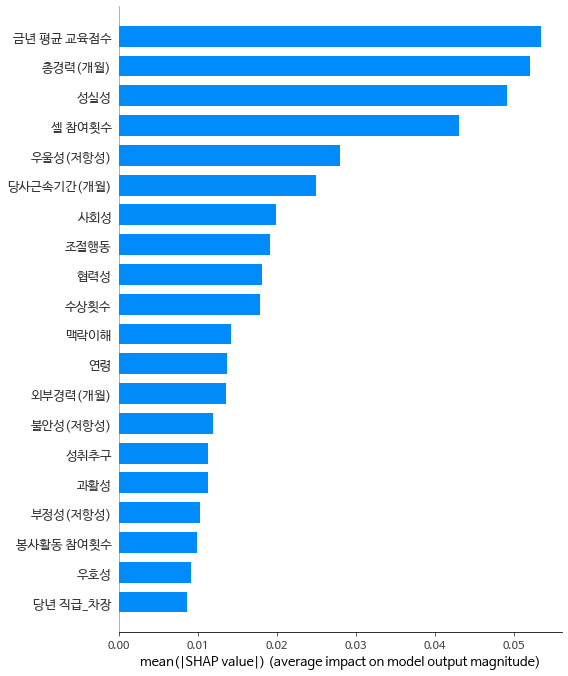

In [ ]:
explainer_2 = shap.TreeExplainer(model_xgb, X_train_s) 
shap_values_2 = explainer_2.shap_values(X_test_s) 
shap.initjs()
shap.summary_plot(shap_values_2, X_test_s, plot_type = "bar")

In [ ]:
importances_2 = np.absolute(shap_values_2).sum(axis=0) / shap_values_2.shape[0]
feature_importance_2 = pd.Series(importances_2 / np.sum(importances_2))
feature_importance_2.index = X_train_s.columns

In [ ]:
fe_list_2 = list(feature_importance_2.index)

In [ ]:
cat_imp_2 = []
for name in categorical : 
  sum = 0
  for i in range (len(fe_list_2)) : 
    if name in fe_list_2[i] :
      sum += feature_importance_2[i]
  cat_imp_2.append(sum)

In [ ]:
cat_fe_2 = pd.Series(cat_imp_2)
cat_fe_2.index = categorical

In [ ]:
nu_fe_2 = feature_importance_2[numerical]

In [ ]:
result_fe_2 = pd.concat([nu_fe_2, cat_fe_2])

In [ ]:
# 수정 1130
result_fe_2 = pd.concat([nu_fe_2, cat_fe_2])

for name in result_fe_2.index.drop(['총경력(개월)']).tolist() : 
  result_fe_2[name] += result_fe_2['총경력(개월)']*0.8/(len(result_fe_2))

value = result_fe_2['총경력(개월)']*0.8/(len(result_fe_2))
result_fe_2['총경력(개월)'] = result_fe_2['총경력(개월)']*0.2 + value

for name in result_fe_2.index.drop(['당사근속기간(개월)']).tolist() : 
  result_fe_2[name] += result_fe_2['당사근속기간(개월)']*0.5/(len(result_fe_2))

value = result_fe_2['당사근속기간(개월)']*0.5/(len(result_fe_2))
result_fe_2['당사근속기간(개월)'] = result_fe_2['당사근속기간(개월)']*0.5 + value

result_fe_2['봉사활동 참여횟수'] += result_fe_2['당년 직급']*0.3
result_fe_2['당년 직급'] = result_fe_2['당년 직급']*0.7

###
result_fe_2['징계횟수'] = result_fe_2['수상횟수']
###

fe_dict_2 = result_fe_2.to_dict()

In [ ]:
# 수정 1117
missing_rate = {}
feature_data = train_data_count[['당년 직급', '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '입사경로', '학력', '전공',
       '거주지', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수', '금년 평균 교육점수', '금년 교육이수 여부', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성',
       '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동',
       '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성',
       '우호성', '협력성', '도덕성', '정직성', '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']].reset_index(drop=True)

for name in feature_data.columns.tolist() : 
  cnt = 0
  for i in range(len(feature_data)) : 
    if feature_data[name].isnull()[i] == True : 
      cnt+=1
    elif feature_data[name][i]=='미입사' : 
      cnt+=1
    elif feature_data[name][i]=='미평가' : 
      cnt+=1
  missing_rate[name] = cnt

missing_rate['all'] = len(feature_data)   

In [ ]:
missing_file_path = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/missing_rate_다면평가.json'

with open(missing_file_path, 'r') as f:
    json_data = json.load(f)

In [ ]:
# 수정 1117
missing_rate_all = {}

same_json = ['당년 직급', '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '입사경로', '학력', '전공', '거주지', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수', '금년 평균 교육점수', '금년 교육이수 여부']
segment = ['전문성_평균평점', '리더십_평균평점', '부하육성_평균평점', '관계관리_평균평점', '조직비전_평균평점', '직책수행능력_평균평점', '조직내 필요성_평균평점', '동반자 의식_평균평점', '직책수행능력', '조직내 필요성', '동반자 의식']
personal = ['긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']

for name in same_json : 
  missing_rate_all[name] = (missing_rate[name]+json_data[name])/(missing_rate['all']+json_data['all'])

for name in segment : 
  missing_rate_all[name] = json_data[name]/(missing_rate['all']+json_data['all'])

for name in personal : 
  missing_rate_all[name] = missing_rate[name]/(missing_rate['all']+json_data['all'])  

In [ ]:
main_dict_1 = {}
main_dict_1['feature importance'] = fe_dict_1
main_dict_1['trainset_size'] = len(X_train)
main_dict_1['testset_size'] = len(X_test)
main_dict_1['total_size'] = len(X_train)+len(X_test)
main_dict_1['last_train_date'] = str(now)
main_dict_1['metrics'] = metrics_dict_1
main_dict_1['algorithm others'] = opt_dict_1
main_dict_1['feature missing rate'] = missing_rate_all

In [ ]:
json_file = json.dumps(main_dict_1)

In [ ]:
file_path_1 = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/인적성_역량평가등급.json'

In [ ]:
with open(file_path_1, 'w', encoding='utf-8') as file:
    file.write(json.dumps(main_dict_1, ensure_ascii=False))

In [ ]:
main_dict_2 = {}
main_dict_2['feature importance'] = fe_dict_2
main_dict_2['trainset_size'] = len(X_train)
main_dict_2['testset_size'] = len(X_test)
main_dict_2['total_size'] = len(X_train)+len(X_test)
main_dict_2['last_train_date'] = str(now)
main_dict_2['metrics'] = metrics_dict_2
main_dict_2['algorithm others'] = opt_dict_2
main_dict_2['feature missing rate'] = missing_rate_all

In [ ]:
json_file = json.dumps(main_dict_2)

In [ ]:
file_path_2 = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/인적성_업적평가등급.json'

In [ ]:
with open(file_path_2, 'w', encoding='utf-8') as file:
    file.write(json.dumps(main_dict_2, ensure_ascii=False))

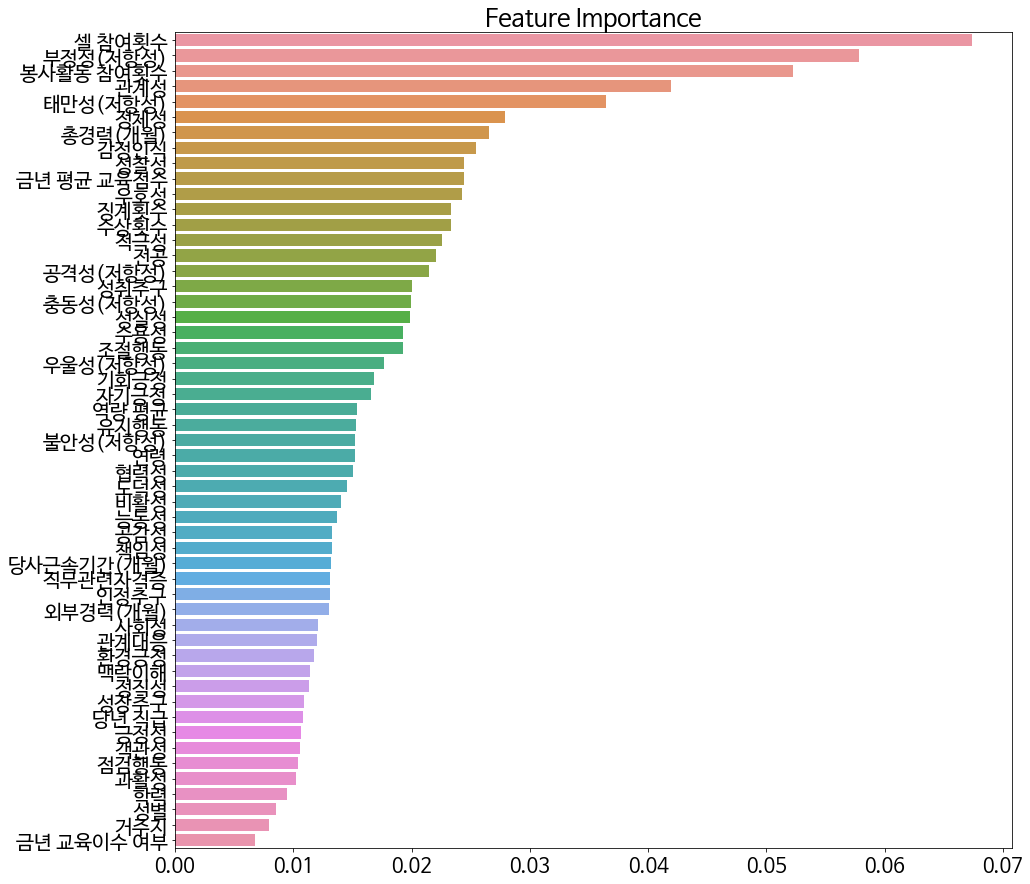

In [ ]:
import seaborn as sns

ft_importance = result_fe_1.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15,15))
plt.rc('font', size=20)  
plt.title('Feature Importance')
sns.barplot(x=ft_importance, y=ft_importance.index)
plt.show()

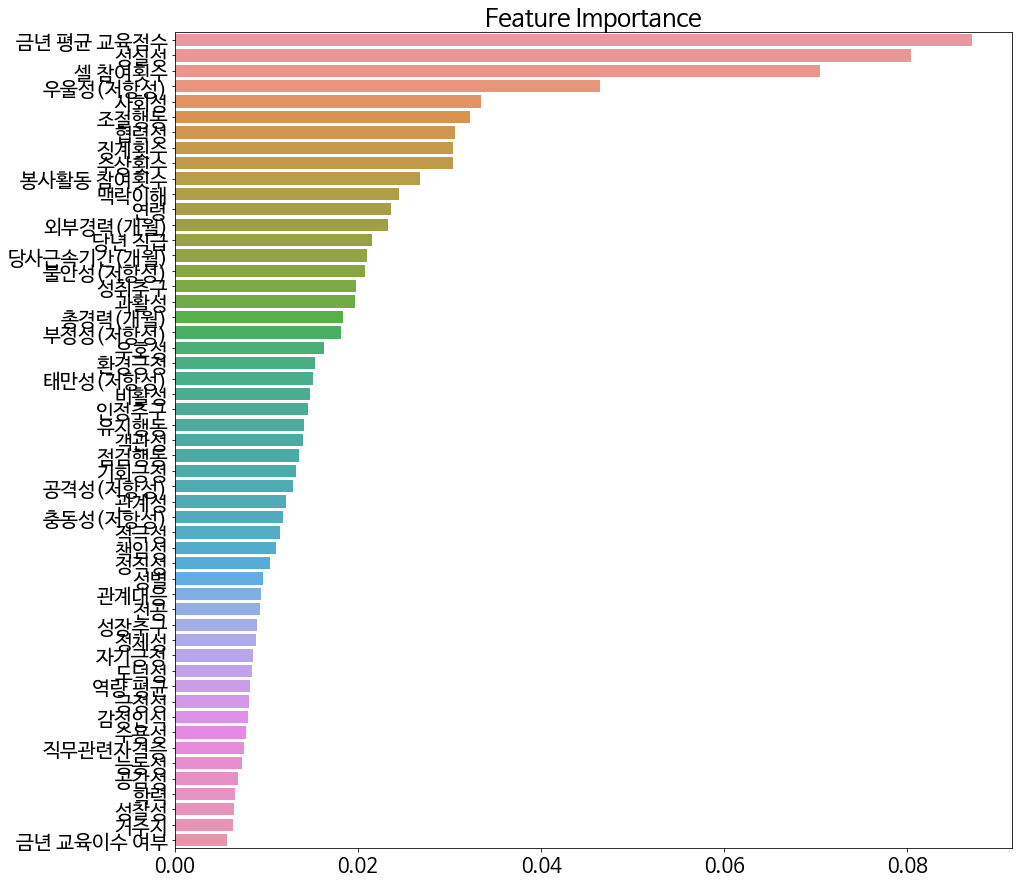

In [ ]:
import seaborn as sns

ft_importance = result_fe_2.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15,15))
plt.rc('font', size=20)  
plt.title('Feature Importance')
sns.barplot(x=ft_importance, y=ft_importance.index)
plt.show()

inference

In [ ]:
inf_data['셀 참여횟수'] = inf_data['셀 참여횟수'].fillna(0)
inf_data['봉사활동 참여횟수'] = inf_data['봉사활동 참여횟수'].fillna(0)
inf_data['금년 평균 교육점수'] = inf_data['금년 평균 교육점수'].replace('미신청', 0)
inf_temp = inf_data.copy()
inf_data['당년 직급'] = inf_data['직급']
inf_data = inf_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책'], axis=1)
# inf_data = inf_data.loc[inf_data['당년 직급']!='미입사']
for name in mind_feature :
  inf_data[name] = inf_data[name].fillna(inf_data[name].mean())

In [ ]:
# 추가 1108
mind_temp = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/NH_1118/mind_22_temp.xlsx', engine='openpyxl')

In [ ]:
# 추가 1108
inf_data['연령'] = mind_temp['연령']
inf_data['당사근속기간(개월)'] = mind_temp['당사근속기간(개월)']
inf_data['총경력(개월)'] = mind_temp['총경력(개월)']
inf_data['직무관련자격증'] = mind_temp['직무관련자격증']
inf_data['수상횟수'] = mind_temp['수상횟수']

In [ ]:
# 수정 1108
inf_x = pd.get_dummies(inf_data.drop(['사번'], axis=1), columns=['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부'], drop_first=True)
inf_x['금년 교육이수 여부_Yes'] = 0
inf_x['당년 직급_사원'] = 0
inf_x.replace('미입사', 0, inplace=True)
inf_x = inf_x[X_train.columns]
inf_x.replace({'직무관련자격증' : '미입사', '수상횟수' : '미입사', '금년 평균 교육점수' : '미입사'}, 0, inplace=True)
inf_x = inf_x.astype('float')

In [ ]:
predictions_rf = model_rf.predict(inf_x)
predictions_xgb = model_xgb.predict(inf_x)

In [ ]:
# 역량 30 50 20 %
# 업적 32 47 21 %
result = pd.DataFrame(columns=['역량평가등급', '업적평가등급'])
result['역량평가등급'] = predictions_rf
result['업적평가등급'] = predictions_xgb

a_grade_f = result['역량평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*0.3-1)]
c_grade_f = result['역량평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*(1-0.2))]
a_grade_s = result['업적평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*0.32-1)]
c_grade_s = result['업적평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*(1-0.21))]

grade_f = []
grade_s = []

for i in range(len(result)) : 
  if result['역량평가등급'][i] >= a_grade_f : 
    grade_f.append("A")
  elif result['역량평가등급'][i] <= c_grade_f : 
    grade_f.append("C")
  else : 
    grade_f.append("B")
  
  if result['업적평가등급'][i] >= a_grade_s : 
    grade_s.append("A")
  elif result['업적평가등급'][i] <= c_grade_s : 
    grade_s.append("C")
  else : 
    grade_s.append("B")

result['역량평가등급_grade'] = grade_f
result['업적평가등급_grade'] = grade_s

In [ ]:
final_result_1 = inf_data.copy()
final_result_1.drop(['역량평가등급', '업적평가등급'], axis=1, inplace=True)
final_result_2 = inf_data.copy()
final_result_2.drop(['역량평가등급', '업적평가등급'], axis=1, inplace=True)
final_result_1['역량평가등급'] = result['역량평가등급']
final_result_1['역량평가등급_grade'] = result['역량평가등급_grade']
final_result_2['업적평가등급'] = result['업적평가등급']
final_result_2['업적평가등급_grade'] = result['업적평가등급_grade']

In [ ]:
# 수정 1108
# inf_temp_1 = inf_temp.loc[inf_temp['당년 직급']!='미입사']
inf_temp_1 =inf_temp[['사번', '성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책']]
# inf_temp_2 = inf_temp.loc[inf_temp['당년 직급']=='미입사']
# inf_temp_2.drop(['역량평가등급', '업적평가등급'], axis=1, inplace=True)

In [ ]:
final_result_1.drop(['사번'], axis=1, inplace=True)
final_result_1 = pd.concat([inf_temp_1, final_result_1], axis=1)
final_result_2.drop(['사번'], axis=1, inplace=True)
final_result_2 = pd.concat([inf_temp_1, final_result_2], axis=1)

In [ ]:
# 수정 1108
'''
final_result_na_1 = inf_temp_2.copy()
final_result_na_1['역량평가등급'] = 0
final_result_na_1['역량평가등급_grade'] = '미대상'

final_result_na_2 = inf_temp_2.copy()
final_result_na_2['업적평가등급'] = 0
final_result_na_2['업적평가등급_grade'] = '미대상'
'''

"\nfinal_result_na_1 = inf_temp_2.copy()\nfinal_result_na_1['역량평가등급'] = 0\nfinal_result_na_1['역량평가등급_grade'] = '미대상'\n\nfinal_result_na_2 = inf_temp_2.copy()\nfinal_result_na_2['업적평가등급'] = 0\nfinal_result_na_2['업적평가등급_grade'] = '미대상'\n"

In [ ]:
# 수정 1108
'''
final_result_1 = pd.concat([final_result_1, final_result_na_1], axis=0)
final_result_2 = pd.concat([final_result_2, final_result_na_2], axis=0)
'''

'\nfinal_result_1 = pd.concat([final_result_1, final_result_na_1], axis=0)\nfinal_result_2 = pd.concat([final_result_2, final_result_na_2], axis=0)\n'

In [ ]:
# 추가
final_result_1['2019_역량평가등급'] = inf['2019_역량평가등급']
final_result_1['2020_역량평가등급'] = inf['2020_역량평가등급']
final_result_1['2021_역량평가등급'] = inf['역량평가등급']

final_result_2['2019_업적평가등급'] = inf['2019_업적평가등급']
final_result_2['2020_업적평가등급'] = inf['2020_업적평가등급']
final_result_2['2021_업적평가등급'] = inf['업적평가등급']

In [ ]:
# 수정 1107
final_result_1.replace({'직급' : ['업무지원역', '기획역']}, '기타', inplace=True)
final_result_2.replace({'직급' : ['업무지원역', '기획역']}, '기타', inplace=True)

In [ ]:
# 수정 1116
attrition = ['정희진', '박영민', '강도이', '박상완']
attrition_idx = []
for i in range(len(final_result_1)) : 
 if final_result_1['성명'][i] in attrition : 
   attrition_idx.append(i)

final_result_1.drop(attrition_idx, inplace=True)
final_result_2.drop(attrition_idx, inplace=True)

In [ ]:
final_result_1[['긍정성', '적극성',
       '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정',
       '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응',
       '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성',
       '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)', '공격성(저항성)',
       '역량 평균']] = inf_temp[['긍정성', '적극성',
       '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정',
       '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응',
       '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성',
       '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)', '공격성(저항성)',
       '역량 평균']]

final_result_2[['긍정성', '적극성',
       '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정',
       '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응',
       '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성',
       '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)', '공격성(저항성)',
       '역량 평균']] = inf_temp[['긍정성', '적극성',
       '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정',
       '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응',
       '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성',
       '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)', '공격성(저항성)',
       '역량 평균']]

In [ ]:
# 추가 1129
final_result_1 = final_result_1.reset_index(drop=True)
final_result_2 = final_result_2.reset_index(drop=True)

punish_list = ['B1210011', 'B1110035', 'B1110036', 'B1110058', 'B1110077', 'B1510023', 'B1510062', 'B1210021', 'B1210076']
punish_data = []
for i in range(len(final_result_1)) : 
  if final_result_1['사번'][i] in punish_list : 
    punish_data.append(1)
  elif final_result_1['사번'][i] == 'B1310064' : 
    punish_data.append(2)
  else : 
    punish_data.append(0)

In [ ]:
# 추가 1129
for i in range(len(punish_data)) : 
  if punish_data[i] == 1 : 
    final_result_1['역량평가등급'][i] = final_result_1['역량평가등급'][i]*(1-0.04)
    final_result_2['업적평가등급'][i] = final_result_2['업적평가등급'][i]*(1-0.04)
  if punish_data[i] == 2 : 
    final_result_1['역량평가등급'][i] = final_result_1['역량평가등급'][i]*(1-0.08)
    final_result_2['업적평가등급'][i] = final_result_2['업적평가등급'][i]*(1-0.08)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
final_result_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/성과관리_인적성_역량평가등급.csv', encoding='utf-8-sig', index=False)
final_result_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/성과관리_인적성_업적평가등급.csv', encoding='utf-8-sig', index=False)

In [ ]:
shap_values_inf_1 = explainer_1.shap_values(inf_x)

pos_max_1 = shap_values_inf_1.max(axis=0)
neg_max_1 = shap_values_inf_1.min(axis=0)
new_list_1 = []
for row in shap_values_inf_1:
  temp = []
  for ele, pos, neg in zip(row, pos_max_1, neg_max_1):
    if ele >= 0:
      if pos == 0: #수정
        temp.append(0)
      else:
        temp.append(ele/pos)
    else:
      if neg == 0:
        temp.append(0)
      else:
        temp.append(-ele/neg)
  new_list_1.append(temp)

feature_weight_1 = pd.DataFrame(new_list_1, index = pd.RangeIndex(len(shap_values_inf_1)), columns = inf_x.columns)
feature_weight_1 = feature_weight_1.fillna(0)

In [ ]:
feature_weight_1.mean()[40:]

부정성(저항성)         -0.096294
태만성(저항성)         -0.043947
불안성(저항성)          0.150439
충동성(저항성)         -0.115930
공격성(저항성)         -0.125685
역량 평균             0.087189
성별_여자            -0.088836
입사경로_신입           0.000000
학력_대졸             0.126477
학력_대학원졸          -0.184446
학력_전졸             0.104302
전공_공학계열           0.041785
전공_교육계열           0.000000
전공_사회계열           0.055230
전공_예체능계열          0.000000
전공_인문계열           0.415502
전공_자연계열          -0.056354
당년 직급_과장         -0.031621
당년 직급_대리         -0.154626
당년 직급_부장          0.011735
당년 직급_사원         -0.242922
당년 직급_이사대우       -0.657305
당년 직급_차장          0.217357
거주지_광주            0.000000
거주지_대구            0.162827
거주지_대전            0.000000
거주지_부산            0.270061
거주지_서울            0.016819
거주지_세종            0.000000
거주지_인천           -0.150132
거주지_충북            0.000000
금년 교육이수 여부_Yes    0.051990
금년 교육이수 여부_미신청   -0.010093
dtype: float64

In [ ]:
categorical_feature = ['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부']
cate_main_1 = []

for i in range(len(feature_weight_1)) :
  temp_1 = []
  for name in categorical_feature : 
    temp_2 = []
    for j in range (len(feature_weight_1.columns.tolist())) : 
      if name in feature_weight_1.columns.tolist()[j] : 
        real_name = feature_weight_1.columns.tolist()[j]
        temp_2.append(feature_weight_1[real_name][i])
    data_sum = np.sum(temp_2)
    temp_1.append(data_sum)
  cate_main_1.append(temp_1)

In [ ]:
ttt_f = pd.DataFrame(cate_main_1, columns=categorical_feature)

feature_weight_1.drop(['성별_여자', '입사경로_신입', '학력_대졸', '학력_대학원졸', '학력_전졸',
       '전공_공학계열', '전공_교육계열', '전공_사회계열', '전공_예체능계열', '전공_인문계열', '전공_자연계열',
       '당년 직급_과장', '당년 직급_대리', '당년 직급_부장', '당년 직급_사원', '당년 직급_이사대우',
       '당년 직급_차장', '거주지_광주', '거주지_대구', '거주지_대전', '거주지_부산', '거주지_서울', '거주지_인천',
       '거주지_충북', '금년 교육이수 여부_Yes', '금년 교육이수 여부_미신청', '거주지_세종'], axis=1, inplace=True)
feature_weight_1 = pd.concat([feature_weight_1, ttt_f], axis=1)

In [ ]:
mm = MinMaxScaler(feature_range=(-1, 1))

for i in range (len(feature_weight_1.max())) : 
  if feature_weight_1.max()[i] > 1 : 
    feature_name = feature_weight_1.max().index[i]
    scaling = mm.fit_transform(feature_weight_1[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_1)) : 
      feature_weight_1[feature_name][j] = scaling[j][0]

for i in range (len(feature_weight_1.min())) : 
  if feature_weight_1.min()[i] < -1 : 
    feature_name = feature_weight_1.min().index[i]
    scaling = mm.fit_transform(feature_weight_1[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_1)) : 
      feature_weight_1[feature_name][j] = scaling[j][0]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
feature_weight_1.insert(0, '사번', inf_data['사번'].tolist())

In [ ]:
shap_values_inf_2 = explainer_2.shap_values(inf_x)

pos_max_2 = shap_values_inf_2.max(axis=0)
neg_max_2 = shap_values_inf_2.min(axis=0)
new_list_2 = []
for row in shap_values_inf_2:
  temp = []
  for ele, pos, neg in zip(row, pos_max_2, neg_max_2):
    if ele >= 0:
      if pos == 0: #수정
        temp.append(0)
      else:
        temp.append(ele/pos)
    else:
      if neg == 0:
        temp.append(0)
      else:
        temp.append(-ele/neg)
  new_list_2.append(temp)

feature_weight_2 = pd.DataFrame(new_list_2, index = pd.RangeIndex(len(shap_values_inf_2)), columns = inf_x.columns)
feature_weight_2 = feature_weight_2.fillna(0)

In [ ]:
cate_main_2 = []

for i in range(len(feature_weight_2)) :
  temp_1 = []
  for name in categorical_feature : 
    temp_2 = []
    for j in range (len(feature_weight_2.columns.tolist())) : 
      if name in feature_weight_2.columns.tolist()[j] : 
        real_name = feature_weight_2.columns.tolist()[j]
        temp_2.append(feature_weight_2[real_name][i])
    data_sum = np.sum(temp_2)
    temp_1.append(data_sum)
  cate_main_2.append(temp_1)

In [ ]:
ttt_s = pd.DataFrame(cate_main_2, columns=categorical_feature)

feature_weight_2.drop(['성별_여자', '입사경로_신입', '학력_대졸', '학력_대학원졸', '학력_전졸',
       '전공_공학계열', '전공_교육계열', '전공_사회계열', '전공_예체능계열', '전공_인문계열', '전공_자연계열',
       '당년 직급_과장', '당년 직급_대리', '당년 직급_부장', '당년 직급_사원', '당년 직급_이사대우',
       '당년 직급_차장', '거주지_광주', '거주지_대구', '거주지_대전', '거주지_부산', '거주지_서울', '거주지_인천',
       '거주지_충북', '금년 교육이수 여부_Yes', '금년 교육이수 여부_미신청', '거주지_세종'], axis=1, inplace=True)
feature_weight_2 = pd.concat([feature_weight_2, ttt_s], axis=1)

In [ ]:
for i in range (len(feature_weight_2.max())) : 
  if feature_weight_2.max()[i] > 1 : 
    feature_name = feature_weight_2.max().index[i]
    scaling = mm.fit_transform(feature_weight_2[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_2)) : 
      feature_weight_2[feature_name][j] = scaling[j][0]

for i in range (len(feature_weight_2.min())) : 
  if feature_weight_2.min()[i] < -1 : 
    feature_name = feature_weight_2.min().index[i]
    scaling = mm.fit_transform(feature_weight_2[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_2)) : 
      feature_weight_2[feature_name][j] = scaling[j][0]

In [ ]:
feature_weight_2.insert(0, '사번', inf_data['사번'].tolist())

In [ ]:
# 수정 1103
feature_weight_1['연령'] = feature_weight_1['연령']*0.1
feature_weight_1['당사근속기간(개월)'] = feature_weight_1['당사근속기간(개월)']*0.1
feature_weight_1['당년 직급'] = feature_weight_1['당년 직급']*0.1
feature_weight_1['외부경력(개월)'] = feature_weight_1['외부경력(개월)']*0.3
feature_weight_1['수상횟수'] = feature_weight_1['수상횟수']*0.2

feature_weight_2['총경력(개월)'] = feature_weight_2['총경력(개월)']*0.8
feature_weight_2['당사근속기간(개월)'] = feature_weight_2['당사근속기간(개월)']*0.5
feature_weight_2['당년 직급'] = feature_weight_2['당년 직급']*0.7

In [ ]:
feature_weight_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/feature_weight_인적성_역량.csv', encoding='utf-8-sig', index=False)
feature_weight_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/feature_weight_인적성_업적.csv', encoding='utf-8-sig', index=False)

In [ ]:
train_prediction_1 = pd.DataFrame(columns=['사번', 'train_predict', 'train_label'])
train_prediction_2 = pd.DataFrame(columns=['사번', 'train_predict', 'train_label'])

In [ ]:
train_prediction_1['사번'] = train_name_f.reset_index(drop=True)
train_prediction_2['사번'] = train_name_s.reset_index(drop=True)
train_prediction_1['train_predict'] = y_train_f.reset_index(drop=True)
train_prediction_2['train_predict'] = y_train_s.reset_index(drop=True)

In [ ]:
train_prediction_1['train_label'] = train_prediction_1['train_predict'].replace({5 : "S", 4 : "A", 3 : "B", 2 : "C", 1 : "D"})
train_prediction_2['train_label'] = train_prediction_2['train_predict'].replace({5 : "S", 4 : "A", 3 : "B", 2 : "C", 1 : "D"})

In [ ]:
train_prediction_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/train_prediction_인적성_역량.csv', encoding='utf-8-sig', index=False)
train_prediction_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/train_prediction_인적성_업적.csv', encoding='utf-8-sig', index=False)

In [ ]:
# 수정 1107
temp_result_1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/성과관리_대상_역량평가등급.csv', encoding='utf-8-sig')
temp_result_2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/성과관리_대상_업적평가등급.csv', encoding='utf-8-sig')

In [ ]:
# 수정 1107
grade_final_result_1 = final_result_1[['사번', '역량평가등급']]
grade_temp_result_1 = temp_result_1[['사번', '역량평가등급']]
grade_result_1 = pd.concat([grade_final_result_1, grade_temp_result_1], axis=0)

grade_final_result_2 = final_result_2[['사번', '업적평가등급']]
grade_temp_result_2 = temp_result_2[['사번', '업적평가등급']]
grade_result_2 = pd.concat([grade_final_result_2, grade_temp_result_2], axis=0)

In [ ]:
grade_result_1 = grade_result_1.sort_values(by='역량평가등급', ascending=False)
grade_1 = grade_result_1.loc[grade_result_1['역량평가등급']!=0].reset_index(drop=True)
a_grade_1 = grade_1['역량평가등급'][round(len(grade_1)*0.3-1)]
c_grade_1 = grade_1['역량평가등급'][round(len(grade_1)*(1-0.2))]

grade_result_2 = grade_result_2.sort_values(by='업적평가등급', ascending=False)
grade_2 = grade_result_2.loc[grade_result_2['업적평가등급']!=0].reset_index(drop=True)
a_grade_2 = grade_2['업적평가등급'][round(len(grade_2)*0.32-1)]
c_grade_2 = grade_2['업적평가등급'][round(len(grade_2)*(1-0.21))]

grade_list_1 = []
grade_list_2 = []

for i in range(len(grade_1)) : 
  if grade_1['역량평가등급'][i] >= a_grade_f : 
    grade_list_1.append("A")
  elif grade_1['역량평가등급'][i] <= c_grade_f : 
    grade_list_1.append("C")
  else : 
    grade_list_1.append("B")
  
  if grade_2['업적평가등급'][i] >= a_grade_s : 
    grade_list_2.append("A")
  elif grade_2['업적평가등급'][i] <= c_grade_s : 
    grade_list_2.append("C")
  else : 
    grade_list_2.append("B")

grade_1['역량평가등급_grade'] = grade_list_1
grade_2['업적평가등급_grade'] = grade_list_2

In [ ]:
not_grade_1 = grade_result_1.loc[grade_result_1['역량평가등급']==0]
grade_1 = pd.concat([grade_1, not_grade_1], axis=0)
grade_1.fillna('미대상', inplace=True)

In [ ]:
not_grade_2 = grade_result_2.loc[grade_result_2['업적평가등급']==0]
grade_2 = pd.concat([grade_2, not_grade_2], axis=0)
grade_2.fillna('미대상', inplace=True)

In [ ]:
grade_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/역량평가등급_grade.csv', encoding='utf-8-sig', index=False)
grade_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/업적평가등급_grade.csv', encoding='utf-8-sig', index=False)

In [ ]:
qwer = final_result_1.dropna(subset=['역량 평균'], axis=0)
qqqq = qwer[numerical]
qqqq['역량평가등급'] = qwer['역량평가등급']
qqqq = qqqq.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
qqqq.replace('미신청', 0, inplace=True)
qqqq.replace('미입사', 0, inplace=True)

In [ ]:
qqqq = qqqq.astype('float')

In [ ]:
ffff= qqqq.corr(method='pearson')

In [ ]:
df = pd.DataFrame(ffff['역량평가등급'].sort_values(ascending=False), columns=['역량평가등급'])
df.style.background_gradient(cmap='viridis')

,역량평가등급
역량평가등급,1.000000
금년 평균 교육점수,0.386621
수상횟수,0.367855
성취추구,0.287710
적극성,0.254464
직무관련자격증,0.251399
셀 참여횟수,0.236088
유지행동,0.156686
인정추구,0.153092
당사근속기간(개월),0.151294


In [ ]:
qwer = final_result_2.dropna(subset=['역량 평균'], axis=0)
qqqq = qwer[numerical]
qqqq['업적평가등급'] = qwer['업적평가등급']
qqqq = qqqq.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
qqqq.replace('미신청', 0, inplace=True)
qqqq.replace('미입사', 0, inplace=True)

In [ ]:
qqqq = qqqq.astype('float')

In [ ]:
ffff= qqqq.corr(method='pearson')

In [ ]:
df = pd.DataFrame(ffff['업적평가등급'].sort_values(ascending=False), columns=['업적평가등급'])
df.style.background_gradient(cmap='viridis')

,업적평가등급
업적평가등급,1.000000
금년 평균 교육점수,0.581907
총경력(개월),0.419399
당사근속기간(개월),0.374562
연령,0.363578
수상횟수,0.341122
셀 참여횟수,0.319311
외부경력(개월),0.279362
성실성,0.257450
조절행동,0.232503
